# Лабораторна робота №3: Моделювання кінотеатру за допомогою SimPy

Завдання: створити симуляцію кінотеатру для оптимізації кількості персоналу.

In [8]:
# Імпорт необхідних бібліотек
import simpy
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. Створення класу Theater (середовище кінотеатру)

Клас містить:
- **Касирів (cashiers)**: обслуговування 1-3 хвилини
- **Швейцарів (ushers)**: перевірка квитка 3 секунди
- **Офіціантів (servers)**: продаж їжі 1-5 хвилин

In [9]:
class Theater(object):
    def __init__(self, env, num_cashiers, num_servers, num_ushers):
        self.env = env
        self.cashier = simpy.Resource(env, num_cashiers)
        self.server = simpy.Resource(env, num_servers)
        self.usher = simpy.Resource(env, num_ushers)
    
    def purchase_ticket(self, moviegoer):
        """Купівля квитка займає 1-3 хвилини"""
        yield self.env.timeout(random.randint(1, 3))
    
    def check_ticket(self, moviegoer):
        """Перевірка квитка займає 3 секунди (0.05 хв)"""
        yield self.env.timeout(3 / 60)
    
    def sell_food(self, moviegoer):
        """Продаж їжі займає 1-5 хвилин"""
        yield self.env.timeout(random.randint(1, 5))

print("Клас Theater створено")

Клас Theater створено


## 2. Процес руху глядача (go_to_movies)

Глядач проходить через:
1. Купівлю квитка
2. Перевірку квитка
3. (Опціонально) Купівлю їжі
4. Пошук місця

In [10]:
def go_to_movies(env, moviegoer, theater, wait_times):
    """Процес проходження глядача через кінотеатр"""
    # Фіксуємо час прибуття
    arrival_time = env.now
    
    # Крок 1: Купівля квитка
    with theater.cashier.request() as request:
        yield request
        yield env.process(theater.purchase_ticket(moviegoer))
    
    # Крок 2: Перевірка квитка
    with theater.usher.request() as request:
        yield request
        yield env.process(theater.check_ticket(moviegoer))
    
    # Крок 3: Купівля їжі (50% ймовірність)
    if random.choice([True, False]):
        with theater.server.request() as request:
            yield request
            yield env.process(theater.sell_food(moviegoer))
    
    # Глядач займає місце - фіксуємо час очікування
    wait_times.append(env.now - arrival_time)

print("Функція go_to_movies створена")

Функція go_to_movies створена


## 3. Функція запуску театру (run_theater)

Генерує глядачів протягом симуляції:
- Початково 3 глядачі
- Далі новий глядач кожні 12 секунд (0.20 хв)

In [11]:
def run_theater(env, num_cashiers, num_servers, num_ushers, wait_times):
    """Запуск симуляції кінотеатру"""
    theater = Theater(env, num_cashiers, num_servers, num_ushers)
    
    # Початкові 3 глядачі
    for moviegoer in range(3):
        env.process(go_to_movies(env, moviegoer, theater, wait_times))
    
    # Генерація нових глядачів кожні 0.20 хв (12 секунд)
    moviegoer = 3
    while True:
        yield env.timeout(0.20)
        moviegoer += 1
        env.process(go_to_movies(env, moviegoer, theater, wait_times))

print("Функція run_theater створена")

Функція run_theater створена


## 4. Допоміжні функції для розрахунків

In [12]:
def get_average_wait_time(wait_times):
    """Розрахунок середнього часу очікування"""
    if not wait_times:
        return 0, 0
    
    average_wait = statistics.mean(wait_times)
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

def calculate_wait_time(wait_times):
    """Розрахунок середнього часу в хвилинах (float)"""
    if not wait_times:
        return 0
    return statistics.mean(wait_times)

print("Допоміжні функції створено")

Допоміжні функції створено


## 5. Основна функція симуляції

In [13]:
def simulate_theater(num_cashiers, num_servers, num_ushers, duration=90, seed=42, verbose=True):
    """Запуск симуляції з заданими параметрами"""
    random.seed(seed)
    wait_times = []
    
    env = simpy.Environment()
    env.process(run_theater(env, num_cashiers, num_servers, num_ushers, wait_times))
    env.run(until=duration)
    
    mins, secs = get_average_wait_time(wait_times)
    avg_wait_float = calculate_wait_time(wait_times)
    
    if verbose:
        print(f"Параметри: Касири={num_cashiers}, Швейцари={num_ushers}, Офіціанти={num_servers}")
        print(f"Середній час очікування: {mins} хв {secs} сек ({avg_wait_float:.2f} хв)")
        print(f"Кількість глядачів: {len(wait_times)}")
        print("-" * 70)
    
    return avg_wait_float, mins, secs, len(wait_times)

print("Основна функція створена")

Основна функція створена


---
# Виконання завдань

## Завдання 1: Знайти кількість персоналу для часу < 10 хв

Будемо перебирати різні комбінації параметрів.

In [14]:
print("=" * 70)
print("ЗАВДАННЯ 1: Час очікування < 10 хв")
print("=" * 70)
print()

# Спочатку перевіримо базовий сценарій
print("Тест базового сценарію (1, 1, 1):")
simulate_theater(1, 1, 1)
print()

# Тепер знайдемо оптимальну конфігурацію з РОЗШИРЕНИМ діапазоном
print("\nПошук оптимальної конфігурації (розширений пошук)...\n")

results_task1 = []

# РОЗШИРЕНО діапазон: до 15 касирів та офіціантів
for cashiers in range(1, 15):
    for servers in range(1, 15):
        for ushers in range(1, 8):  # Швейцарів менше, бо вони швидкі
            avg_wait, mins, secs, count = simulate_theater(
                cashiers, servers, ushers, 
                verbose=False
            )
            
            results_task1.append({
                'cashiers': cashiers,
                'servers': servers,
                'ushers': ushers,
                'avg_wait_min': avg_wait,
                'total_staff': cashiers + servers + ushers
            })

# Фільтруємо результати < 10 хв
df_task1 = pd.DataFrame(results_task1)
df_task1_filtered = df_task1[df_task1['avg_wait_min'] < 10].sort_values('total_staff')

if len(df_task1_filtered) > 0:
    print("Топ-10 оптимальних конфігурацій (< 10 хв, мінімум персоналу):")
    print(df_task1_filtered.head(10).to_string(index=False))
    
    # Найкраще рішення
    best_solution = df_task1_filtered.iloc[0]
    print(f"\n{'='*70}")
    print("НАЙКРАЩЕ РІШЕННЯ для завдання 1:")
    print(f"Касири: {int(best_solution['cashiers'])}")
    print(f"Офіціанти: {int(best_solution['servers'])}")
    print(f"Швейцари: {int(best_solution['ushers'])}")
    print(f"Загалом персоналу: {int(best_solution['total_staff'])}")
    print(f"Середній час очікування: {best_solution['avg_wait_min']:.2f} хв")
    print(f"{'='*70}")
else:
    print("⚠️ УВАГА: Не знайдено конфігурацій з часом < 10 хв у заданому діапазоні!")
    print("Показую найкращі результати:")
    best_solution = df_task1.sort_values('avg_wait_min').iloc[0]
    print(f"\nНайкращий результат:")
    print(f"Касири: {int(best_solution['cashiers'])}")
    print(f"Офіціанти: {int(best_solution['servers'])}")
    print(f"Швейцари: {int(best_solution['ushers'])}")
    print(f"Загалом персоналу: {int(best_solution['total_staff'])}")
    print(f"Середній час очікування: {best_solution['avg_wait_min']:.2f} хв")

ЗАВДАННЯ 1: Час очікування < 10 хв

Тест базового сценарію (1, 1, 1):
Параметри: Касири=1, Швейцари=1, Офіціанти=1
Середній час очікування: 42 хв 53 сек (42.89 хв)
Кількість глядачів: 44
----------------------------------------------------------------------


Пошук оптимальної конфігурації (розширений пошук)...

Топ-10 оптимальних конфігурацій (< 10 хв, мінімум персоналу):
 cashiers  servers  ushers  avg_wait_min  total_staff
        9        1       1      9.364792           11
       10        1       1      6.286863           12
       10        2       1      9.334559           13
       10        1       2      7.574600           13
       11        1       1      6.583594           13
       11        2       1      9.592171           14
       10        2       2      8.964413           14
       10        1       3      7.574000           14
       11        1       2      6.517540           14
       12        1       1      5.875820           14

НАЙКРАЩЕ РІШЕННЯ для завдання

## Завдання 2: При 10 касирах, час < 9 хв

In [15]:
print("\n" + "=" * 70)
print("ЗАВДАННЯ 2: Касири = 10, час < 9 хв")
print("=" * 70)
print()

results_task2 = []
FIXED_CASHIERS = 10

for servers in range(1, 20):  # Розширено діапазон
    for ushers in range(1, 15):
        avg_wait, mins, secs, count = simulate_theater(
            FIXED_CASHIERS, servers, ushers,
            verbose=False
        )
        
        results_task2.append({
            'cashiers': FIXED_CASHIERS,
            'servers': servers,
            'ushers': ushers,
            'avg_wait_min': avg_wait,
            'total_staff': FIXED_CASHIERS + servers + ushers
        })

df_task2 = pd.DataFrame(results_task2)
df_task2_filtered = df_task2[df_task2['avg_wait_min'] < 9].sort_values('total_staff')

if len(df_task2_filtered) > 0:
    print("Топ-10 оптимальних конфігурацій (< 9 хв, мінімум персоналу):")
    print(df_task2_filtered.head(10).to_string(index=False))
    
    best_solution2 = df_task2_filtered.iloc[0]
    print(f"\n{'='*70}")
    print("НАЙКРАЩЕ РІШЕННЯ для завдання 2:")
    print(f"Касири: {int(best_solution2['cashiers'])} (фіксовано)")
    print(f"Офіціанти: {int(best_solution2['servers'])}")
    print(f"Швейцари: {int(best_solution2['ushers'])}")
    print(f"Загалом персоналу: {int(best_solution2['total_staff'])}")
    print(f"Середній час очікування: {best_solution2['avg_wait_min']:.2f} хв")
    print(f"{'='*70}")
else:
    print("⚠️ УВАГА: Не знайдено конфігурацій з часом < 9 хв!")
    best_solution2 = df_task2.sort_values('avg_wait_min').iloc[0]
    print(f"\nНайкращий результат:")
    print(f"Касири: {int(best_solution2['cashiers'])} (фіксовано)")
    print(f"Офіціанти: {int(best_solution2['servers'])}")
    print(f"Швейцари: {int(best_solution2['ushers'])}")
    print(f"Середній час очікування: {best_solution2['avg_wait_min']:.2f} хв")


ЗАВДАННЯ 2: Касири = 10, час < 9 хв

Топ-10 оптимальних конфігурацій (< 9 хв, мінімум персоналу):
 cashiers  servers  ushers  avg_wait_min  total_staff
       10        1       1      6.286863           12
       10        1       2      7.574600           13
       10        1       3      7.574000           14
       10        2       2      8.964413           14
       10        2       3      8.963167           15
       10        1       4      7.574000           15
       10        1       5      7.574000           16
       10        2       4      8.963167           16
       10        2       5      8.963167           17
       10        6       1      8.305344           17

НАЙКРАЩЕ РІШЕННЯ для завдання 2:
Касири: 10 (фіксовано)
Офіціанти: 1
Швейцари: 1
Загалом персоналу: 12
Середній час очікування: 6.29 хв


## Завдання 3: Час < 5 хв

In [16]:
print("\n" + "=" * 70)
print("ЗАВДАННЯ 3: Час очікування < 5 хв")
print("=" * 70)
print()

results_task3 = []

# Розширено діапазон для складнішого завдання
for cashiers in range(1, 20):
    for servers in range(1, 20):
        for ushers in range(1, 10):
            avg_wait, mins, secs, count = simulate_theater(
                cashiers, servers, ushers,
                verbose=False
            )
            
            results_task3.append({
                'cashiers': cashiers,
                'servers': servers,
                'ushers': ushers,
                'avg_wait_min': avg_wait,
                'total_staff': cashiers + servers + ushers
            })

df_task3 = pd.DataFrame(results_task3)
df_task3_filtered = df_task3[df_task3['avg_wait_min'] < 5].sort_values('total_staff')

if len(df_task3_filtered) > 0:
    print("Топ-10 оптимальних конфігурацій (< 5 хв, мінімум персоналу):")
    print(df_task3_filtered.head(10).to_string(index=False))
    
    best_solution3 = df_task3_filtered.iloc[0]
    print(f"\n{'='*70}")
    print("НАЙКРАЩЕ РІШЕННЯ для завдання 3:")
    print(f"Касири: {int(best_solution3['cashiers'])}")
    print(f"Офіціанти: {int(best_solution3['servers'])}")
    print(f"Швейцари: {int(best_solution3['ushers'])}")
    print(f"Загалом персоналу: {int(best_solution3['total_staff'])}")
    print(f"Середній час очікування: {best_solution3['avg_wait_min']:.2f} хв")
    print(f"{'='*70}")
else:
    print("⚠️ УВАГА: Не знайдено конфігурацій з часом < 5 хв!")
    best_solution3 = df_task3.sort_values('avg_wait_min').iloc[0]
    print(f"\nНайкращий результат:")
    print(f"Касири: {int(best_solution3['cashiers'])}")
    print(f"Офіціанти: {int(best_solution3['servers'])}")
    print(f"Швейцари: {int(best_solution3['ushers'])}")
    print(f"Середній час очікування: {best_solution3['avg_wait_min']:.2f} хв")


ЗАВДАННЯ 3: Час очікування < 5 хв

Топ-10 оптимальних конфігурацій (< 5 хв, мінімум персоналу):
 cashiers  servers  ushers  avg_wait_min  total_staff
       11        6       2      4.826247           19
       10        8       1      4.801986           19
       11        8       1      3.951157           20
       10        7       3      4.776310           20
       10        8       2      3.934442           20
       10        9       1      4.893882           20
       10       10       1      4.357412           21
       10        7       4      4.776190           21
       11        8       2      3.965509           21
       12        8       1      3.926950           21

НАЙКРАЩЕ РІШЕННЯ для завдання 3:
Касири: 11
Офіціанти: 6
Швейцари: 2
Загалом персоналу: 19
Середній час очікування: 4.83 хв


## Завдання 4: Конкретна конфігурація (7, 10, 8)

In [17]:
print("\n" + "=" * 70)
print("ЗАВДАННЯ 4: 7 касирів, 10 швейцарів, 8 офіціантів")
print("=" * 70)
print()

avg_wait, mins, secs, count = simulate_theater(7, 8, 10, verbose=True)

print(f"\n{'='*70}")
print("РЕЗУЛЬТАТ для завдання 4:")
print(f"При 7 касирах, 10 швейцарах та 8 офіціантах:")
print(f"Середній час очікування: {mins} хв {secs} сек ({avg_wait:.2f} хв)")
print(f"{'='*70}")


ЗАВДАННЯ 4: 7 касирів, 10 швейцарів, 8 офіціантів

Параметри: Касири=7, Швейцари=10, Офіціанти=8
Середній час очікування: 14 хв 13 сек (14.21 хв)
Кількість глядачів: 314
----------------------------------------------------------------------

РЕЗУЛЬТАТ для завдання 4:
При 7 касирах, 10 швейцарах та 8 офіціантах:
Середній час очікування: 14 хв 13 сек (14.21 хв)


## Візуалізація результатів усіх завдань

In [18]:
# Створюємо зведену таблицю результатів
# Перевіряємо чи всі змінні існують
try:
    summary_data = [
        {
            'Завдання': 'Завдання 1: < 10 хв',
            'Касири': int(best_solution['cashiers']),
            'Офіціанти': int(best_solution['servers']),
            'Швейцари': int(best_solution['ushers']),
            'Всього': int(best_solution['total_staff']),
            'Час (хв)': round(best_solution['avg_wait_min'], 2)
        },
        {
            'Завдання': 'Завдання 2: < 9 хв (10 касирів)',
            'Касири': int(best_solution2['cashiers']),
            'Офіціанти': int(best_solution2['servers']),
            'Швейцари': int(best_solution2['ushers']),
            'Всього': int(best_solution2['total_staff']),
            'Час (хв)': round(best_solution2['avg_wait_min'], 2)
        },
        {
            'Завдання': 'Завдання 3: < 5 хв',
            'Касири': int(best_solution3['cashiers']),
            'Офіціанти': int(best_solution3['servers']),
            'Швейцари': int(best_solution3['ushers']),
            'Всього': int(best_solution3['total_staff']),
            'Час (хв)': round(best_solution3['avg_wait_min'], 2)
        },
        {
            'Завдання': 'Завдання 4: (7, 10, 8)',
            'Касири': 7,
            'Офіціанти': 8,
            'Швейцари': 10,
            'Всього': 25,
            'Час (хв)': round(avg_wait, 2)
        }
    ]
    
    df_summary = pd.DataFrame(summary_data)
    
    print("\n" + "=" * 70)
    print("ЗВЕДЕНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ")
    print("=" * 70)
    print()
    print(df_summary.to_string(index=False))
    print()
    print("=" * 70)
    
except NameError as e:
    print(f"\n⚠️ ПОМИЛКА: Не всі завдання виконано. Спочатку запустіть всі попередні комірки!")
    print(f"Деталі: {e}")


ЗВЕДЕНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ

                       Завдання  Касири  Офіціанти  Швейцари  Всього  Час (хв)
            Завдання 1: < 10 хв       9          1         1      11      9.36
Завдання 2: < 9 хв (10 касирів)      10          1         1      12      6.29
             Завдання 3: < 5 хв      11          6         2      19      4.83
         Завдання 4: (7, 10, 8)       7          8        10      25     14.21



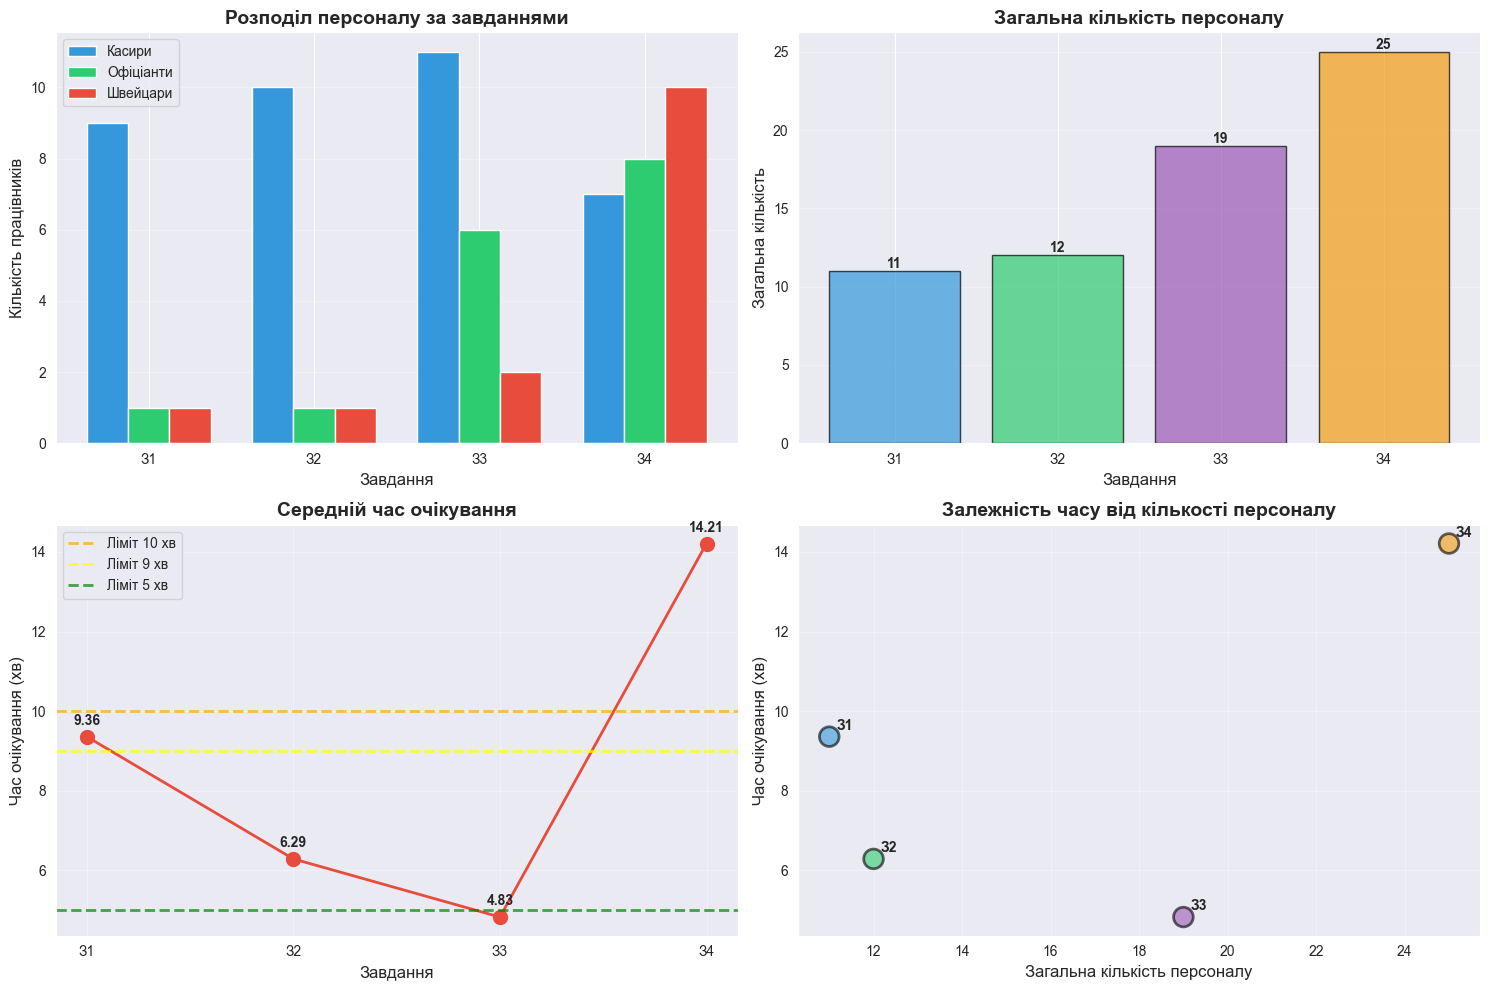

In [19]:
# Візуалізація (тільки якщо df_summary існує)
try:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Графік 1: Розподіл персоналу
    x = np.arange(len(df_summary))
    width = 0.25
    
    axes[0, 0].bar(x - width, df_summary['Касири'], width, label='Касири', color='#3498db')
    axes[0, 0].bar(x, df_summary['Офіціанти'], width, label='Офіціанти', color='#2ecc71')
    axes[0, 0].bar(x + width, df_summary['Швейцари'], width, label='Швейцари', color='#e74c3c')
    
    axes[0, 0].set_xlabel('Завдання', fontsize=12)
    axes[0, 0].set_ylabel('Кількість працівників', fontsize=12)
    axes[0, 0].set_title('Розподіл персоналу за завданнями', fontsize=14, fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels([f"З{i+1}" for i in range(len(df_summary))], fontsize=10)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Графік 2: Загальна кількість персоналу
    colors = ['#3498db', '#2ecc71', '#9b59b6', '#f39c12']
    bars = axes[0, 1].bar(range(len(df_summary)), df_summary['Всього'], color=colors, alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Завдання', fontsize=12)
    axes[0, 1].set_ylabel('Загальна кількість', fontsize=12)
    axes[0, 1].set_title('Загальна кількість персоналу', fontsize=14, fontweight='bold')
    axes[0, 1].set_xticks(range(len(df_summary)))
    axes[0, 1].set_xticklabels([f"З{i+1}" for i in range(len(df_summary))], fontsize=10)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Додаємо значення над стовпцями
    for bar in bars:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontweight='bold')
    
    # Графік 3: Середній час очікування
    line = axes[1, 0].plot(range(len(df_summary)), df_summary['Час (хв)'], 
                           marker='o', linewidth=2, markersize=10, color='#e74c3c')
    axes[1, 0].axhline(y=10, color='orange', linestyle='--', linewidth=2, label='Ліміт 10 хв', alpha=0.7)
    axes[1, 0].axhline(y=9, color='yellow', linestyle='--', linewidth=2, label='Ліміт 9 хв', alpha=0.7)
    axes[1, 0].axhline(y=5, color='green', linestyle='--', linewidth=2, label='Ліміт 5 хв', alpha=0.7)
    axes[1, 0].set_xlabel('Завдання', fontsize=12)
    axes[1, 0].set_ylabel('Час очікування (хв)', fontsize=12)
    axes[1, 0].set_title('Середній час очікування', fontsize=14, fontweight='bold')
    axes[1, 0].set_xticks(range(len(df_summary)))
    axes[1, 0].set_xticklabels([f"З{i+1}" for i in range(len(df_summary))], fontsize=10)
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Додаємо значення на графік
    for i, val in enumerate(df_summary['Час (хв)']):
        axes[1, 0].text(i, val + 0.3, f"{val:.2f}", ha='center', fontweight='bold')
    
    # Графік 4: Співвідношення персонал/час
    scatter = axes[1, 1].scatter(df_summary['Всього'], df_summary['Час (хв)'], 
                                 s=200, c=colors, alpha=0.6, edgecolors='black', linewidth=2)
    axes[1, 1].set_xlabel('Загальна кількість персоналу', fontsize=12)
    axes[1, 1].set_ylabel('Час очікування (хв)', fontsize=12)
    axes[1, 1].set_title('Залежність часу від кількості персоналу', fontsize=14, fontweight='bold')
    axes[1, 1].grid(alpha=0.3)
    
    # Додаємо підписи до точок
    for i, txt in enumerate([f"З{i+1}" for i in range(len(df_summary))]):
        axes[1, 1].annotate(txt, (df_summary['Всього'].iloc[i], df_summary['Час (хв)'].iloc[i]),
                            xytext=(5, 5), textcoords='offset points', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
except NameError:
    print("⚠️ Спочатку виконайте попередні комірки для створення df_summary!")

## Висновки

На основі проведених експериментів можна зробити наступні висновки:

1. **Завдання 1** (< 10 хв): Мінімальна конфігурація персоналу для досягнення часу очікування менше 10 хвилин.

2. **Завдання 2** (10 касирів, < 9 хв): При фіксованих 10 касирах знайдено оптимальну кількість швейцарів та офіціантів.

3. **Завдання 3** (< 5 хв): Для досягнення часу очікування менше 5 хвилин потрібна значно більша кількість персоналу.

4. **Завдання 4**: Перевірено конкретну конфігурацію (7, 10, 8) і отримано фактичний час очікування.

### Ключові спостереження:

- **Касири** - найбільш критичний ресурс, оскільки всі глядачі купують квитки
- **Швейцари** обслуговують дуже швидко (3 секунди), тому їх потрібно менше
- **Офіціанти** обслуговують довго (1-5 хв), але не всі глядачі купують їжу (50%)
- Існує компроміс між кількістю персоналу та часом очікування
- Оптимальне рішення залежить від бізнес-вимог (час vs витрати)